In [2]:
import pandas as pd
final_df = pd.read_csv('uubar.csv')

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [4]:
print(final_df.keys())
final_df.head()

Index(['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4',
       'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4',
       'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4',
       'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3',
       'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3',
       'subjetmt4', 'Q_1_0', 'Q_1_0.3', 'Q_1_0.5', 'Q_1_0.7', 'Q_1_1',
       'Q_1_0_square', 'Q_1_0.3_square', 'Q_1_0.5_square', 'Q_1_0.7_square',
       'Q_1_1_square', 'Q_2_0', 'Q_2_0.3', 'Q_2_0.5', 'Q_2_0.7', 'Q_2_1',
       'Q_2_0_square', 'Q_2_0.3_square', 'Q_2_0.5_square', 'Q_2_0.7_square',
       'Q_2_1_square', 'Q_3_0', 'Q_3_0.3', 'Q_3_0.5', 'Q_3_0.7', 'Q_3_1',
       'Q_4_0', 'Q_4_0.3', 'Q_4_0.5', 'Q_4_0.7', 'Q_4_1', 'Q_5_0', 'Q_5_0.3',
       'Q_5_0.5', 'Q_5_0.7', 'Q_5_1', 'Q_6_0', 'Q_6_0.3', 'Q_6_0.5', 'Q_6_0.7',
       'Q_6_1', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'jet_type'],
      dtype='

,subjetpT0,subjetpT1,subjetpT2,subjetpT3,subjetpT4,subjeteta0,subjeteta1,subjeteta2,subjeteta3,subjeteta4,...,Q_5_1,Q_6_0,Q_6_0.3,Q_6_0.5,Q_6_0.7,Q_6_1,charge ratio,jet_charge,charge_asymmetry,jet_type
0,7.058072,6.358462,5.186489,3.826047,3.730435,0.635624,0.630064,1.781071,0.504422,0.472687,...,0.150934,1.0,0.823041,0.696428,0.577876,0.425625,0.933333,-1.0,0.000000,1.0
1,4.145579,2.521786,1.909426,0.980833,0.900864,-0.735833,-0.699752,-0.833568,-0.751420,-0.854555,...,0.184013,-3.0,-1.667053,-1.118118,-0.744160,-0.396564,3.000000,4.0,0.000000,1.0
2,10.199473,9.963601,4.735384,2.891007,1.930021,2.157630,2.096738,1.965430,1.932615,2.183731,...,0.242318,4.0,2.789371,2.193498,1.724917,1.202858,0.500000,-1.0,0.000000,1.0
3,6.062532,4.461598,4.117556,3.889703,3.539303,0.244864,-1.244864,-0.737077,-1.257961,-0.600617,...,-0.067950,-1.0,-0.516892,-0.319471,-0.186985,-0.067950,0.909091,-2.0,-0.666667,1.0
4,14.102426,4.117096,4.083389,3.087446,2.920695,0.659219,-0.053328,0.527523,-0.196722,-0.222644,...,-0.457682,3.0,1.455823,0.828539,0.408732,0.032321,1.000000,0.0,0.000000,1.0


In [5]:
# Count NaNs in each column and remove rows with NaN
NDIM = len(final_df.keys()) - 1
print("Number of features:", NDIM)
print("All features:", final_df.keys())

df_nonan = final_df.copy()
df_nonan = df_nonan.dropna()
#print(df_nonan.isna().sum())

dataset_nonan = df_nonan.values
X = dataset_nonan[:,0:NDIM]
Y = dataset_nonan[:,NDIM]

train_mask, test_mask = train_test_split(np.arange(len(Y)), test_size=0.2, random_state=42)


Number of features: 68
All features: Index(['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4',
       'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4',
       'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4',
       'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3',
       'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3',
       'subjetmt4', 'Q_1_0', 'Q_1_0.3', 'Q_1_0.5', 'Q_1_0.7', 'Q_1_1',
       'Q_1_0_square', 'Q_1_0.3_square', 'Q_1_0.5_square', 'Q_1_0.7_square',
       'Q_1_1_square', 'Q_2_0', 'Q_2_0.3', 'Q_2_0.5', 'Q_2_0.7', 'Q_2_1',
       'Q_2_0_square', 'Q_2_0.3_square', 'Q_2_0.5_square', 'Q_2_0.7_square',
       'Q_2_1_square', 'Q_3_0', 'Q_3_0.3', 'Q_3_0.5', 'Q_3_0.7', 'Q_3_1',
       'Q_4_0', 'Q_4_0.3', 'Q_4_0.5', 'Q_4_0.7', 'Q_4_1', 'Q_5_0', 'Q_5_0.3',
       'Q_5_0.5', 'Q_5_0.7', 'Q_5_1', 'Q_6_0', 'Q_6_0.3', 'Q_6_0.5', 'Q_6_0.7',
       'Q_6_1', 'charge ratio', 'jet_charge', 'charge_a

## Node classification

In [ ]:
# Count NaNs in each column and remove rows with NaN
NDIM = len(final_df.keys()) - 1
print("Number of features:", NDIM)
print("All features:", final_df.keys())

df_nonan = final_df.copy()
df_nonan = df_nonan.dropna()
#print(df_nonan.isna().sum())

dataset_nonan = df_nonan.values
X = dataset_nonan[:,0:NDIM]
Y = dataset_nonan[:,NDIM]

# Preprocess the data: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create edge index for a fully connected graph
# For demonstration, a simple fully connected graph is created.
# In practice, you should create an edge_index based on your data's graph structure.
edge_index = torch.tensor(np.array([(i, j) for i in range(len(X)) for j in range(len(X)) if i != j]).T, dtype=torch.long)

# Convert data to torch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float)
Y_tensor = torch.tensor(Y, dtype=torch.long)

# Create a PyTorch Geometric data object
data = Data(x=X_tensor, edge_index=edge_index, y=Y_tensor)

# Split the data into training and testing sets
train_mask, test_mask = train_test_split(np.arange(len(Y)), test_size=0.2, random_state=42)

# Create masks for PyTorch Geometric
data.train_mask = torch.tensor(train_mask, dtype=torch.long)
data.test_mask = torch.tensor(test_mask, dtype=torch.long)

Number of features: 68
All features: Index(['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4',
       'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4',
       'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4',
       'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3',
       'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3',
       'subjetmt4', 'Q_1_0', 'Q_1_0.3', 'Q_1_0.5', 'Q_1_0.7', 'Q_1_1',
       'Q_1_0_square', 'Q_1_0.3_square', 'Q_1_0.5_square', 'Q_1_0.7_square',
       'Q_1_1_square', 'Q_2_0', 'Q_2_0.3', 'Q_2_0.5', 'Q_2_0.7', 'Q_2_1',
       'Q_2_0_square', 'Q_2_0.3_square', 'Q_2_0.5_square', 'Q_2_0.7_square',
       'Q_2_1_square', 'Q_3_0', 'Q_3_0.3', 'Q_3_0.5', 'Q_3_0.7', 'Q_3_1',
       'Q_4_0', 'Q_4_0.3', 'Q_4_0.5', 'Q_4_0.7', 'Q_4_1', 'Q_5_0', 'Q_5_0.3',
       'Q_5_0.5', 'Q_5_0.7', 'Q_5_1', 'Q_6_0', 'Q_6_0.3', 'Q_6_0.5', 'Q_6_0.7',
       'Q_6_1', 'charge ratio', 'jet_charge', 'charge_a

In [ ]:
# GCN model to classify graph-level
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Create the model
model = GCN(in_channels=68, hidden_channels=16, out_channels=2)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing function
def test():
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.size(0)
    return acc

# Training loop
for epoch in range(50):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

# Final test accuracy
acc = test()
print(f'Final Test Accuracy: {acc:.4f}')


Epoch: 0, Loss: 0.6931, Test Accuracy: 0.5447
Epoch: 10, Loss: 0.6867, Test Accuracy: 0.5447
Epoch: 20, Loss: 0.6862, Test Accuracy: 0.5447
Epoch: 30, Loss: 0.6863, Test Accuracy: 0.5447
Epoch: 40, Loss: 0.6862, Test Accuracy: 0.5447
Final Test Accuracy: 0.5447


## Graph classification

### GCN model

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assume final_df contains graph data (e.g., node features and labels for multiple graphs)
# Example: final_df has columns [feature1, feature2, ..., label]

# Count features and prepare data
NDIM = len(final_df.keys()) - 1  # Number of features (excluding label)
print("Number of features:", NDIM)
print("All features:", final_df.keys())

# Remove rows with NaN
df_nonan = final_df.dropna()
dataset_nonan = df_nonan.values
X = dataset_nonan[:, 0:NDIM]
Y = dataset_nonan[:, NDIM]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a list of Data objects (one per graph)
# Placeholder: assumes small graphs with num_nodes_per_graph nodes each
def create_graph_data(X, y, num_nodes_per_graph=10):
    data_list = []
    for i in range(0, len(X), num_nodes_per_graph):
        x = X[i:i+num_nodes_per_graph]
        if len(x) < num_nodes_per_graph:
            continue  # Skip incomplete graphs
        x_tensor = torch.tensor(x, dtype=torch.float)
        
        # Placeholder: fully connected graph (replace with your actual edge logic)
        edge_index = torch.tensor(
            [[i, j] for i in range(len(x)) for j in range(len(x)) if i != j],
            dtype=torch.long
        ).t().contiguous()
        
        # Graph label
        y_tensor = torch.tensor([y[i]], dtype=torch.long)
        
        data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)
        data_list.append(data)
    return data_list

# Create dataset
data_list = create_graph_data(X_scaled, Y)

# Split into train and test sets
train_idx, test_idx = train_test_split(range(len(data_list)), test_size=0.2, random_state=42)
train_data = [data_list[i] for i in train_idx]
test_data = [data_list[i] for i in test_idx]

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# GCN model for graph classification with dropout
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)  # Dropout with 50% probability

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after first layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after second layer
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Create model
num_classes = len(np.unique(Y))
model = GCN(in_channels=NDIM, hidden_channels=4, out_channels=num_classes)  # Reduced hidden channels

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)  # Increased weight decay
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Testing function
def test(loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        out = model(data)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)
    return correct / total

# Function to collect predictions for ROC curve
def get_predictions(loader):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for data in loader:
            out = model(data)
            probs = torch.exp(out)[:, 1].cpu().numpy()
            y_true.extend(data.y.cpu().numpy())
            y_scores.extend(probs)
    return np.array(y_true), np.array(y_scores)

# Plot accuracy per epoch
def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(test_accuracies, label='Test Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_per_epoch.png')
    plt.close()

# Training loop with early stopping
patience = 10
best_test_acc = 0
epochs_no_improve = 0
train_accuracies = []
test_accuracies = []

for epoch in range(50):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # Early stopping
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        epochs_no_improve = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

# Load best model for final evaluation
model.load_state_dict(torch.load('best_model.pth'))

# Final accuracies
train_acc = test(train_loader)
test_acc = test(test_loader)
print(f'Final Train Accuracy: {train_acc:.4f}')
print(f'Final Test Accuracy: {test_acc:.4f}')

# Plot accuracy per epoch
plot_accuracy(train_accuracies, test_accuracies)

# Compute ROC curve and AUC for test set
y_true, y_scores = get_predictions(test_loader)
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

Number of features: 68
All features: Index(['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4',
       'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4',
       'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4',
       'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3',
       'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3',
       'subjetmt4', 'Q_1_0', 'Q_1_0.3', 'Q_1_0.5', 'Q_1_0.7', 'Q_1_1',
       'Q_1_0_square', 'Q_1_0.3_square', 'Q_1_0.5_square', 'Q_1_0.7_square',
       'Q_1_1_square', 'Q_2_0', 'Q_2_0.3', 'Q_2_0.5', 'Q_2_0.7', 'Q_2_1',
       'Q_2_0_square', 'Q_2_0.3_square', 'Q_2_0.5_square', 'Q_2_0.7_square',
       'Q_2_1_square', 'Q_3_0', 'Q_3_0.3', 'Q_3_0.5', 'Q_3_0.7', 'Q_3_1',
       'Q_4_0', 'Q_4_0.3', 'Q_4_0.5', 'Q_4_0.7', 'Q_4_1', 'Q_5_0', 'Q_5_0.3',
       'Q_5_0.5', 'Q_5_0.7', 'Q_5_1', 'Q_6_0', 'Q_6_0.3', 'Q_6_0.5', 'Q_6_0.7',
       'Q_6_1', 'charge ratio', 'jet_charge', 'charge_a

C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Loss: 0.5714, Train Acc: 0.7800, Test Acc: 0.7674
Epoch: 10, Loss: 0.4586, Train Acc: 0.7917, Test Acc: 0.7631
Early stopping at epoch 17
Final Train Accuracy: 0.8059
Final Test Accuracy: 0.7787


C:\Users\meisa\AppData\Local\Temp\ipykernel_44304\2638220376.py:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


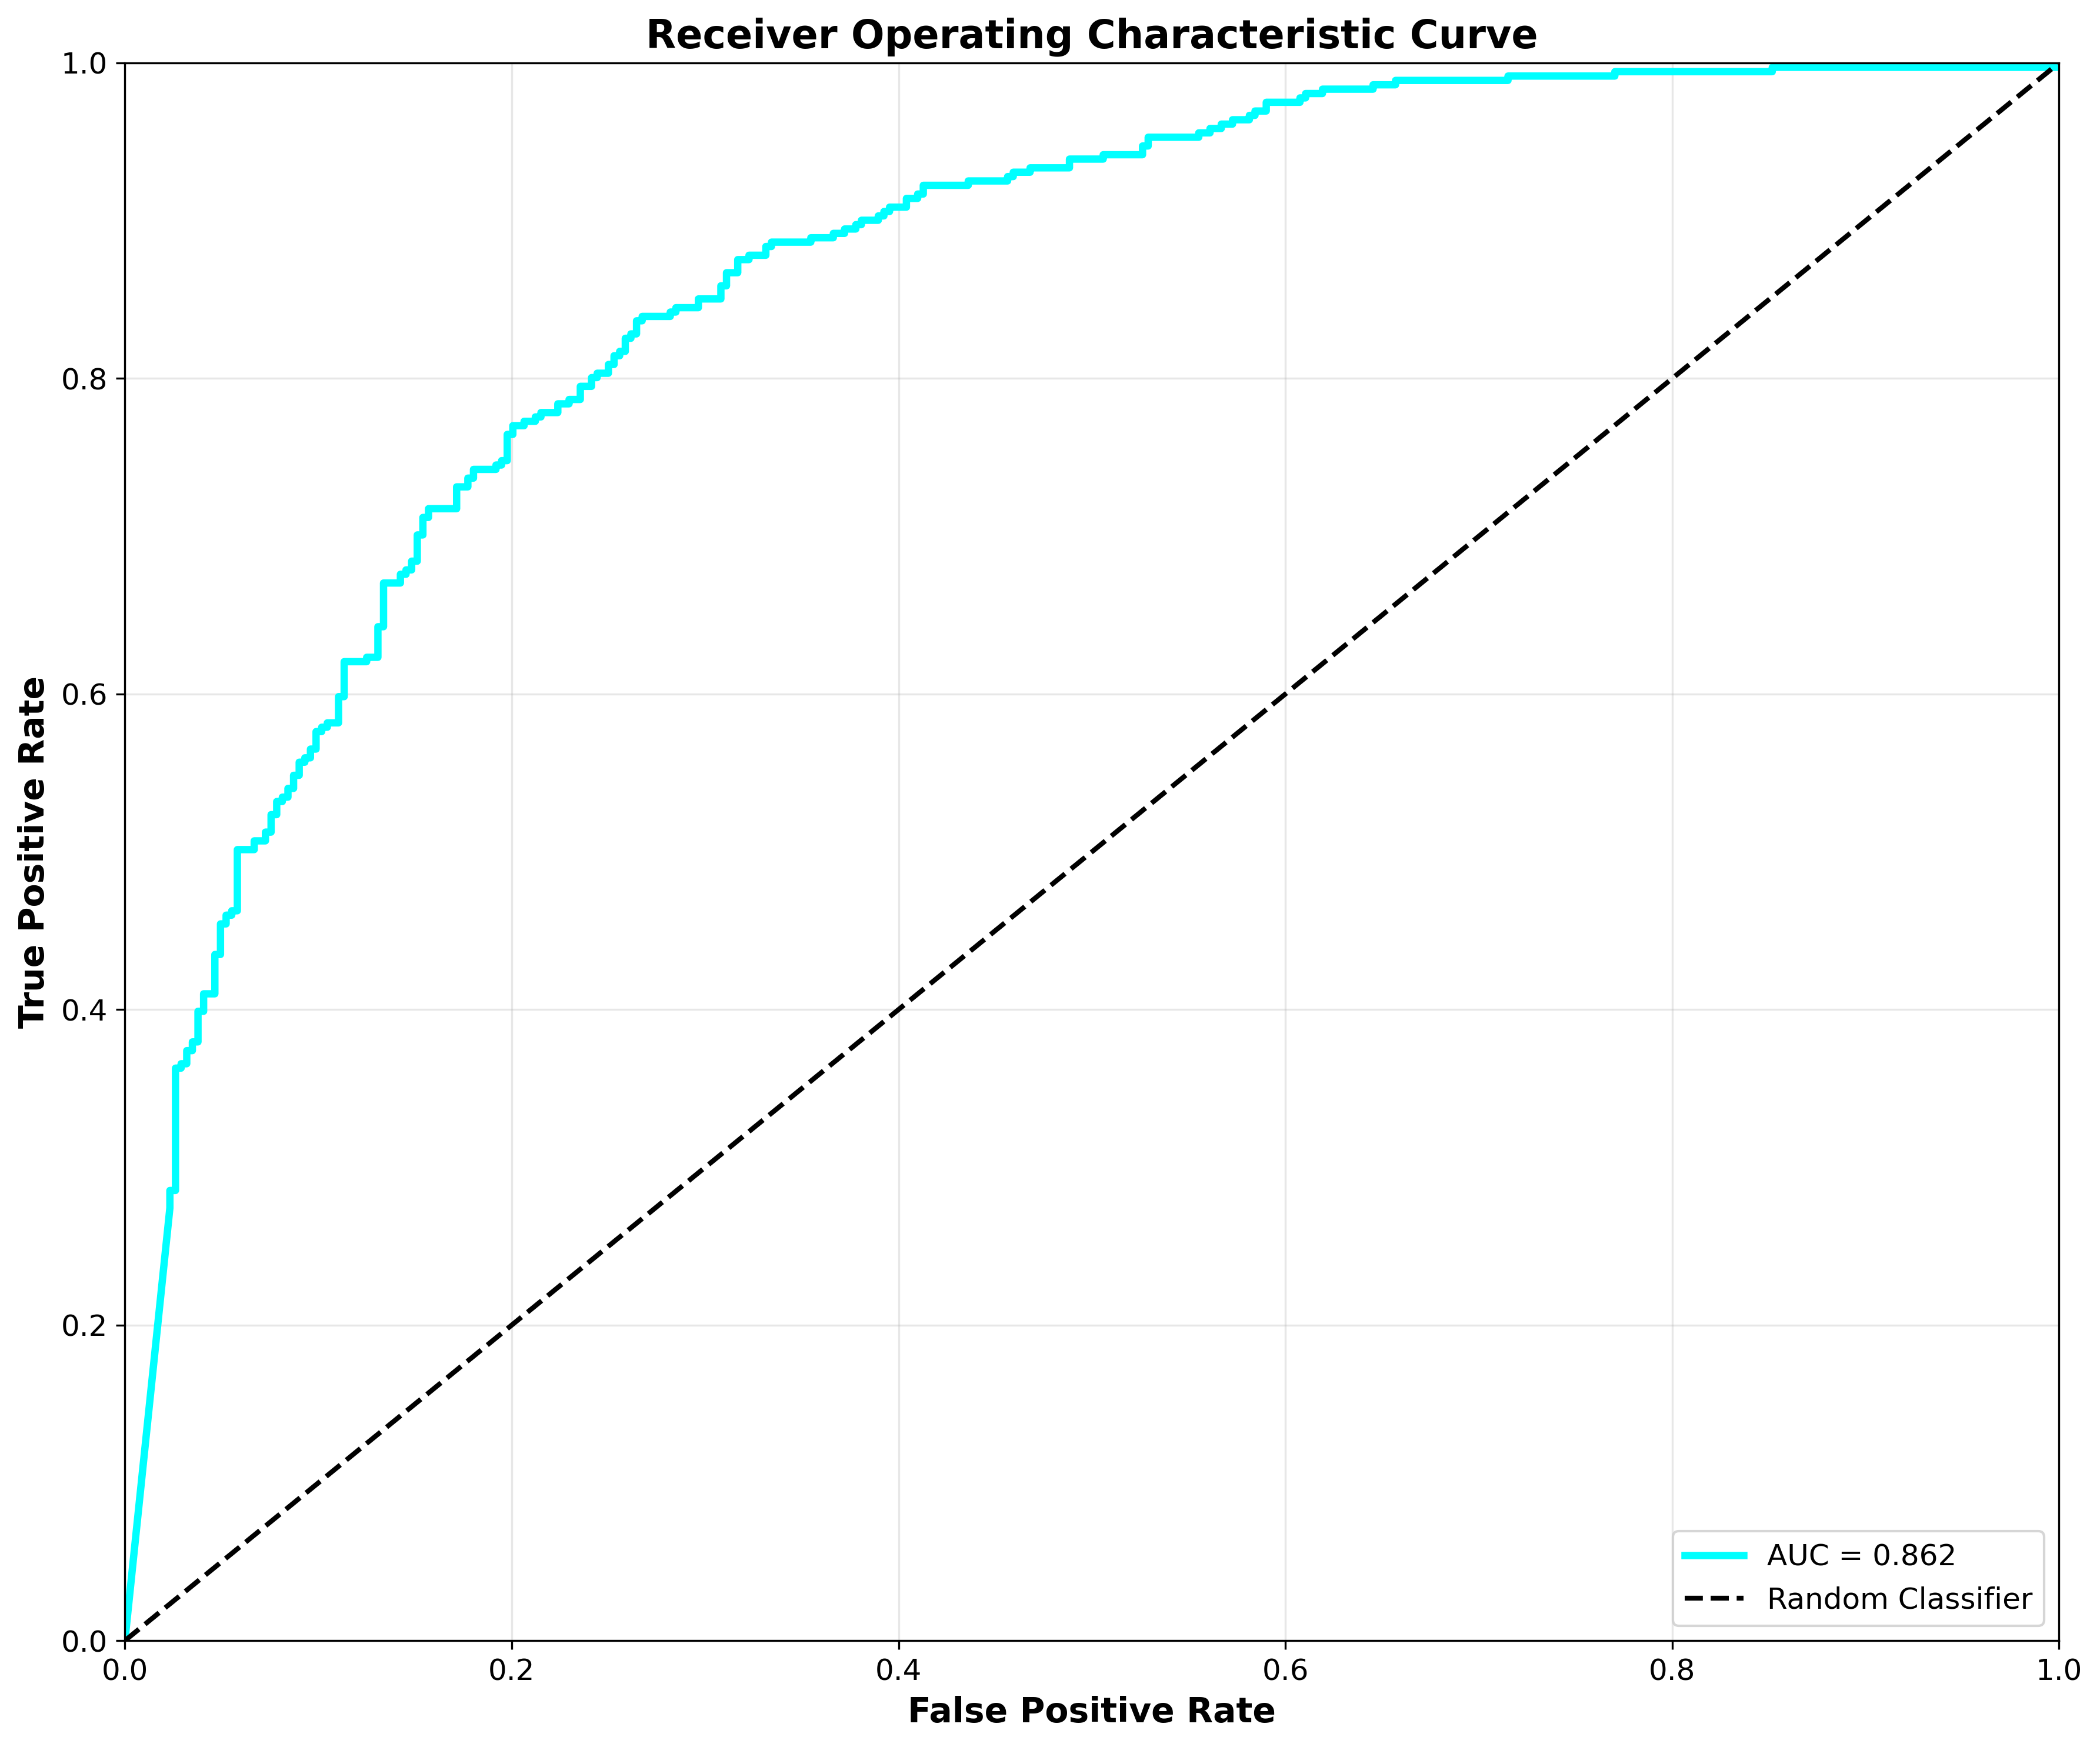

In [7]:
def ROC_plot(tpr, fpr, figsize=(12, 10), dpi=300):
    """
    Simplified version matching your original function but with high resolution
    """
    # Set up high resolution figure
    plt.figure(figsize=figsize, dpi=dpi)
    
    # Plot ROC
    roc_auc = auc(fpr, tpr)

    ax = plt.subplot(1, 1, 1)
    ax.plot(fpr, tpr, lw=3, color='cyan', label='AUC = %.3f' % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random Classifier')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    ax.set_title('Receiver Operating Characteristic Curve', fontsize=16, fontweight='bold')
    ax.legend(loc="lower right", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.savefig('roc_curve.png')
    plt.tight_layout()
    plt.show() 

ROC_plot(tpr, fpr)


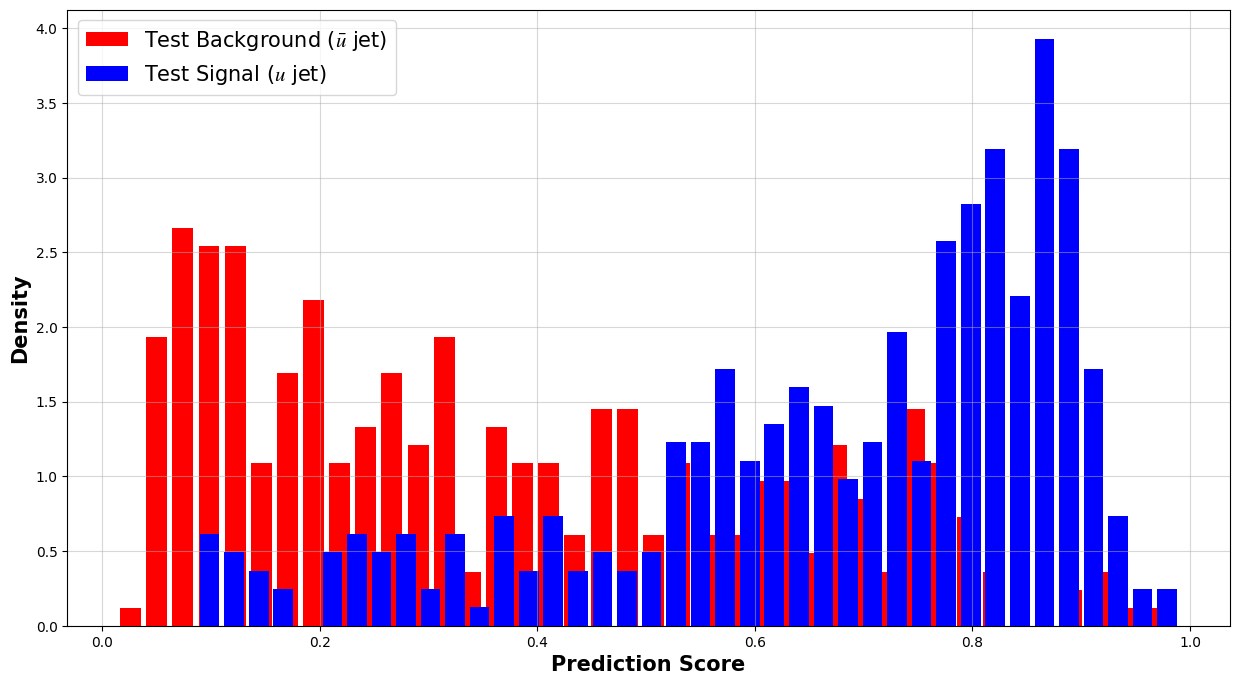

In [55]:
# Plot score distributions for signal and background
def plot_score_distributions(y_true_train, y_scores_train, y_true_test, y_scores_test, kappa):
    plt.rc('text', usetex=False)
    plt.rc('mathtext', fontset='stix')
    plt.figure(figsize=(15, 8))
    # Testing set
    plt.hist(y_scores_test[y_true_test == 0], bins=40, alpha=1., color='red', label=r'Test Background ($\bar{u}$ jet)', density=True, rwidth=0.8)
    plt.hist(y_scores_test[y_true_test == 1], bins=40, alpha=1., color='blue', label=r'Test Signal ($u$ jet)', density=True, rwidth=0.8)
    plt.xlabel('Prediction Score', fontsize=15, fontweight='bold')
    plt.ylabel('Density', fontsize=15, fontweight='bold')
    plt.legend(fontsize=15)
    plt.grid(True, alpha=0.5)
    plt.show()

# Function to collect predictions for ROC curve and distributions
def get_predictions(model, loader):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for data in loader:
            out = model(data)
            probs = torch.exp(out)[:, 1].cpu().numpy()  # Probability for jet_type=1 (signal)
            y_true.extend(data.y.cpu().numpy())
            y_scores.extend(probs)
    return np.array(y_true), np.array(y_scores)

y_true_train, y_scores_train = get_predictions(model, train_loader)
plot_score_distributions(y_true_train, y_scores_train, y_true_test, y_scores_test, kappa)

### GraphSAGE model

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assume final_df contains graph data (e.g., node features and labels for multiple graphs)
# Example: final_df has columns [feature1, feature2, ..., label]

# Count features and prepare data
NDIM = len(final_df.keys()) - 1  # Number of features (excluding label)
print("Number of features:", NDIM)
print("All features:", final_df.keys())

# Remove rows with NaN
df_nonan = final_df.dropna()
dataset_nonan = df_nonan.values
X = dataset_nonan[:, 0:NDIM]
Y = dataset_nonan[:, NDIM]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a list of Data objects (one per graph)
# Placeholder: assumes small graphs with num_nodes_per_graph nodes each
def create_graph_data(X, y, num_nodes_per_graph=10):
    data_list = []
    for i in range(0, len(X), num_nodes_per_graph):
        x = X[i:i+num_nodes_per_graph]
        if len(x) < num_nodes_per_graph:
            continue  # Skip incomplete graphs
        x_tensor = torch.tensor(x, dtype=torch.float)
        
        # Placeholder: fully connected graph (replace with your actual edge logic)
        edge_index = torch.tensor(
            [[i, j] for i in range(len(x)) for j in range(len(x)) if i != j],
            dtype=torch.long
        ).t().contiguous()
        
        # Graph label
        y_tensor = torch.tensor([y[i]], dtype=torch.long)
        
        data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)
        data_list.append(data)
    return data_list

# Create dataset
data_list = create_graph_data(X_scaled, Y)

# Split into train and test sets
train_idx, test_idx = train_test_split(range(len(data_list)), test_size=0.2, random_state=42)
train_data = [data_list[i] for i in train_idx]
test_data = [data_list[i] for i in test_idx]

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# GraphSAGE model for graph classification with dropout
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr='mean')
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr='mean')
        self.fc = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)  # Dropout with 50% probability

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after first layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after second layer
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Create model
num_classes = len(np.unique(Y))
model = GraphSAGE(in_channels=NDIM, hidden_channels=8, out_channels=num_classes)  # Reduced hidden channels

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)  # Increased weight decay
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Testing function
def test(loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        out = model(data)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)
    return correct / total

# Function to collect predictions for ROC curve
def get_predictions(loader):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for data in loader:
            out = model(data)
            probs = torch.exp(out)[:, 1].cpu().numpy()
            y_true.extend(data.y.cpu().numpy())
            y_scores.extend(probs)
    return np.array(y_true), np.array(y_scores)

# Plot accuracy per epoch
def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(test_accuracies, label='Test Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_per_epoch.png')
    plt.close()

# Training loop with early stopping
patience = 10
best_test_acc = 0
epochs_no_improve = 0
train_accuracies = []
test_accuracies = []

for epoch in range(50):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # Early stopping
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

# Load best model for final evaluation
model.load_state_dict(torch.load('best_model.pth'))

# Final accuracies
train_acc_sage = test(train_loader)
test_acc_sage = test(test_loader)
print(f'Final Train Accuracy: {train_acc_sage:.4f}')
print(f'Final Test Accuracy: {test_acc_sage:.4f}')

# Plot accuracy per epoch
plot_accuracy(train_accuracies, test_accuracies)

# Compute ROC curve and AUC for test set
y_true, y_scores = get_predictions(test_loader)
fpr_sage, tpr_sage, _ = roc_curve(y_true, y_scores)
roc_auc_sage = auc(fpr_sage, tpr_sage)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_sage:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve.png')
plt.close()

Number of features: 68
All features: Index(['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4',
       'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4',
       'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4',
       'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3',
       'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3',
       'subjetmt4', 'Q_1_0', 'Q_1_0.3', 'Q_1_0.5', 'Q_1_0.7', 'Q_1_1',
       'Q_1_0_square', 'Q_1_0.3_square', 'Q_1_0.5_square', 'Q_1_0.7_square',
       'Q_1_1_square', 'Q_2_0', 'Q_2_0.3', 'Q_2_0.5', 'Q_2_0.7', 'Q_2_1',
       'Q_2_0_square', 'Q_2_0.3_square', 'Q_2_0.5_square', 'Q_2_0.7_square',
       'Q_2_1_square', 'Q_3_0', 'Q_3_0.3', 'Q_3_0.5', 'Q_3_0.7', 'Q_3_1',
       'Q_4_0', 'Q_4_0.3', 'Q_4_0.5', 'Q_4_0.7', 'Q_4_1', 'Q_5_0', 'Q_5_0.3',
       'Q_5_0.5', 'Q_5_0.7', 'Q_5_1', 'Q_6_0', 'Q_6_0.3', 'Q_6_0.5', 'Q_6_0.7',
       'Q_6_1', 'charge ratio', 'jet_charge', 'charge_a

C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Loss: 0.5236, Train Acc: 0.7984, Test Acc: 0.7688
Epoch: 10, Loss: 0.4288, Train Acc: 0.8240, Test Acc: 0.7702
Epoch: 20, Loss: 0.4434, Train Acc: 0.8336, Test Acc: 0.7745
Early stopping at epoch 21


C:\Users\meisa\AppData\Local\Temp\ipykernel_43384\706744654.py:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Final Train Accuracy: 0.8208
Final Test Accuracy: 0.8071


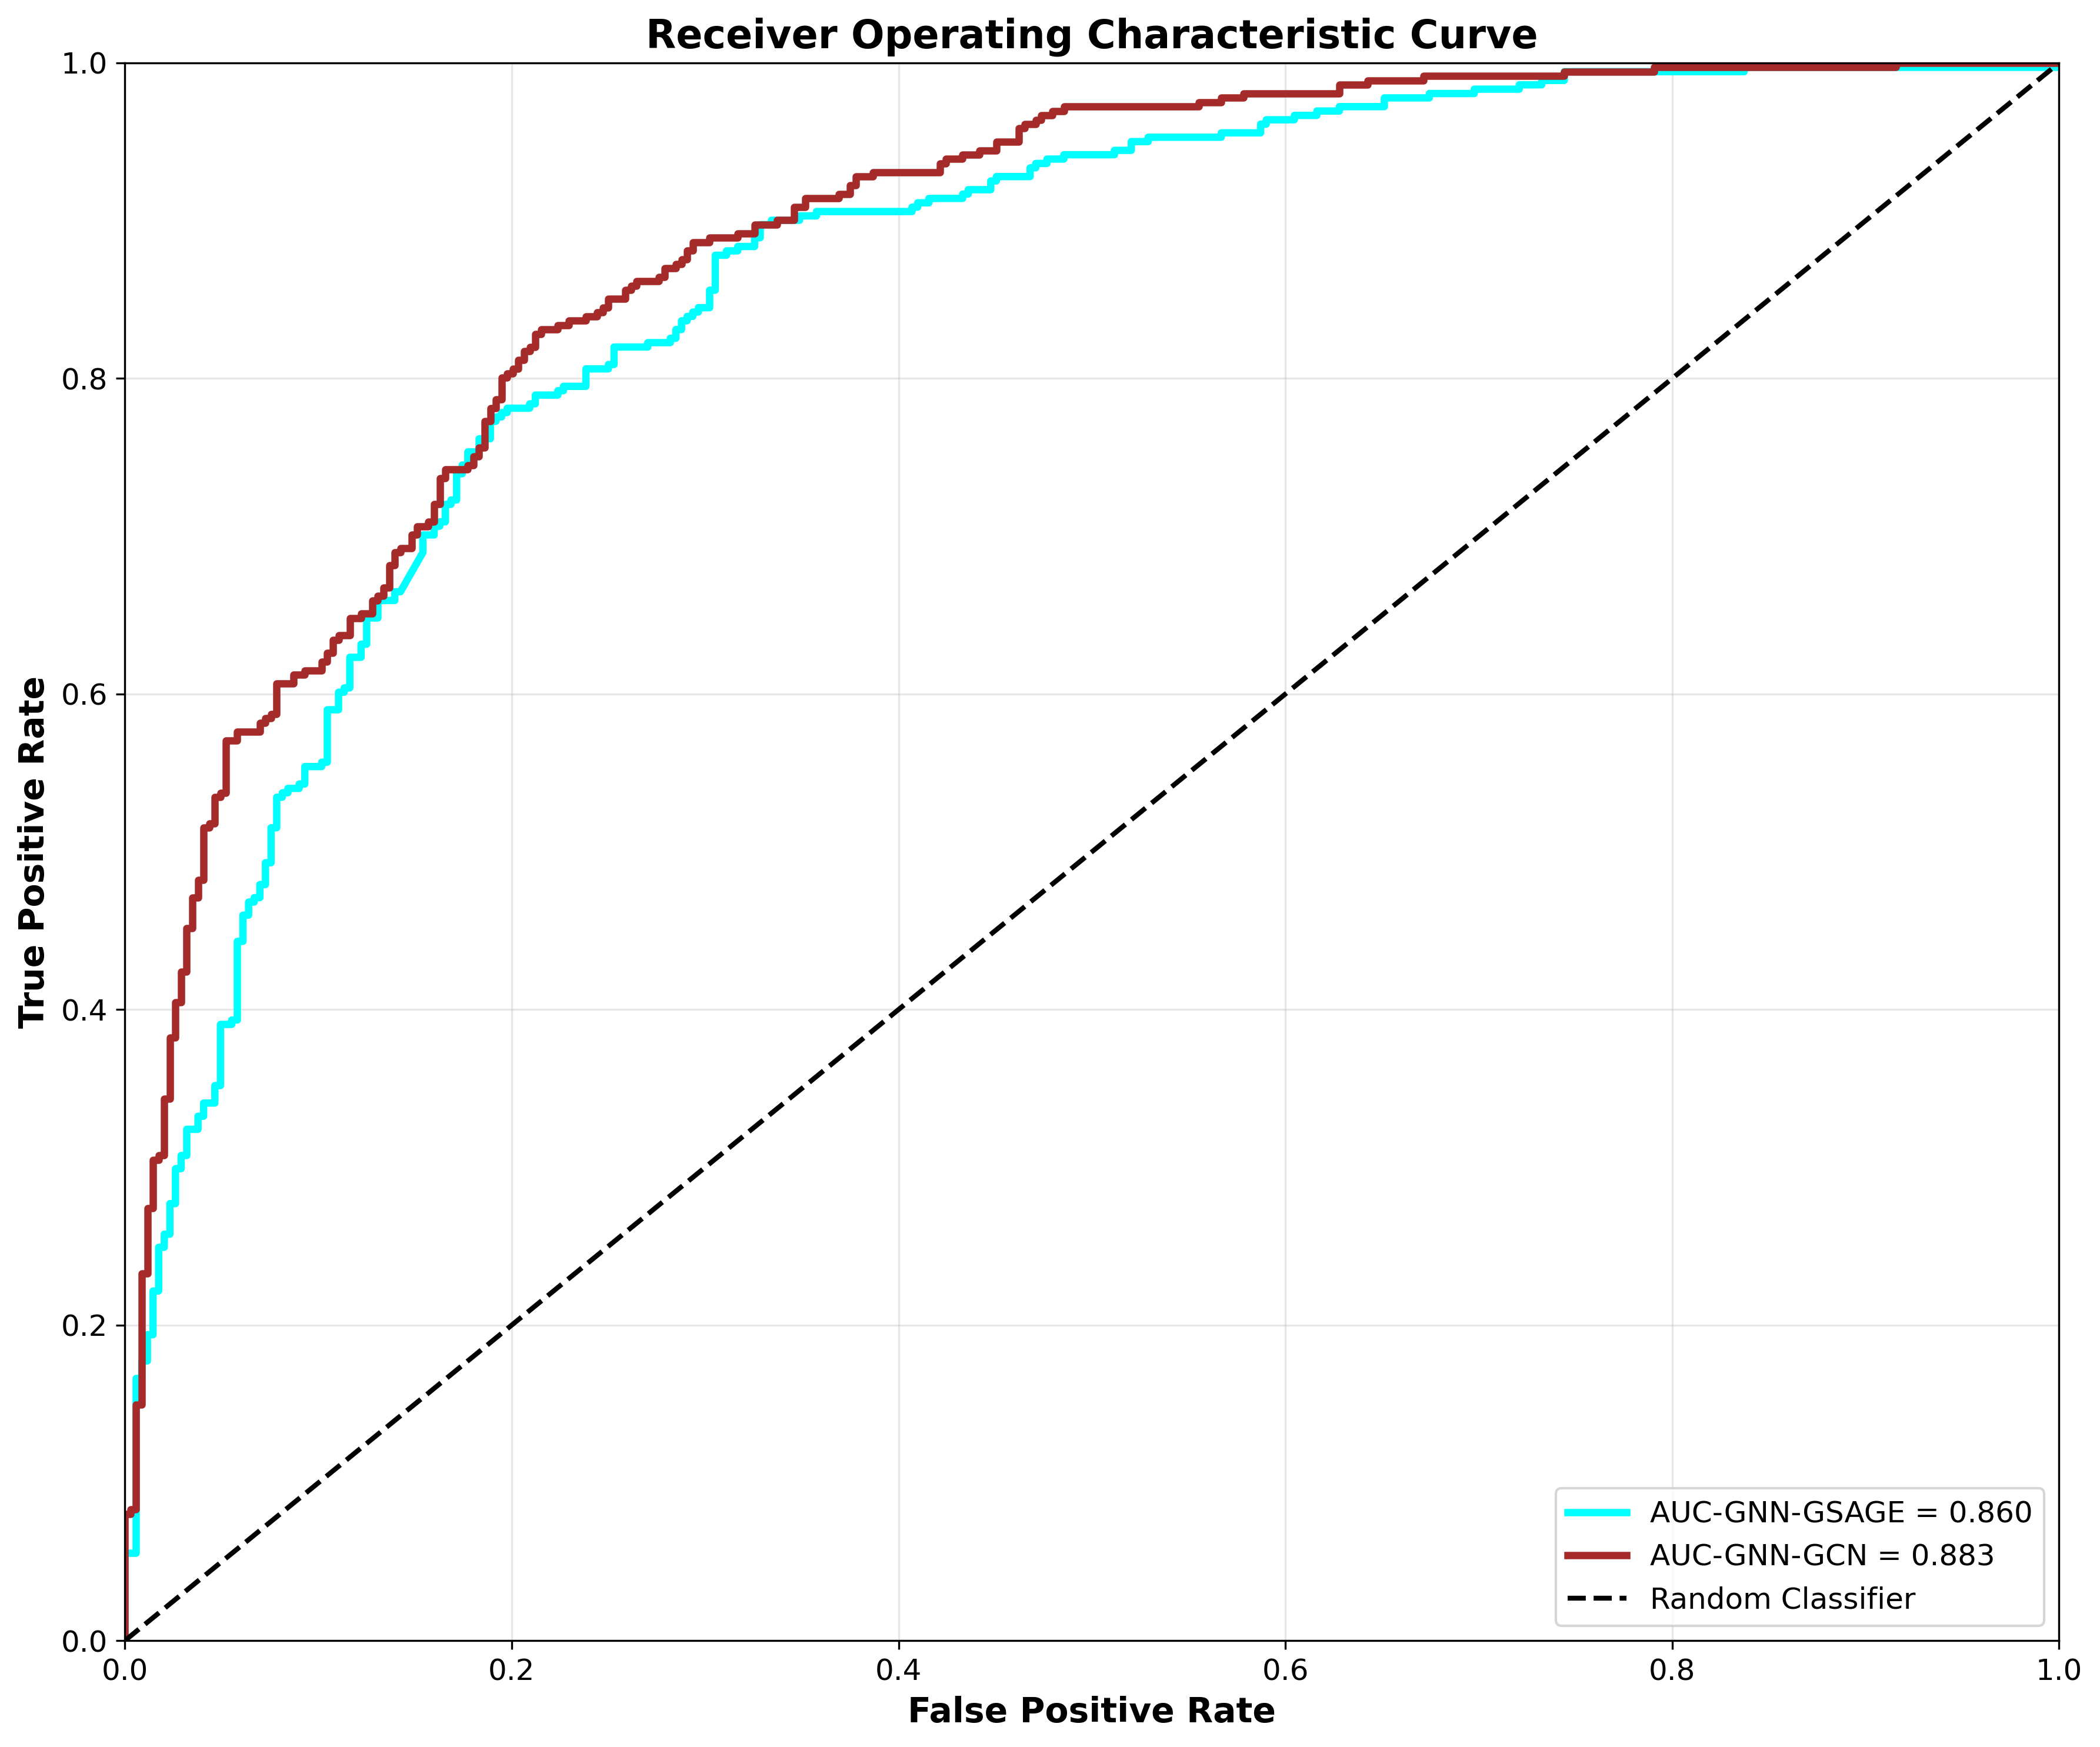

In [28]:
def ROC_plot(tpr, fpr, tpr_sage, fpr_sage, figsize=(12, 10), dpi=300):
    """
    Simplified version matching your original function but with high resolution
    """
    # Set up high resolution figure
    plt.figure(figsize=figsize, dpi=dpi)
    
    # Plot ROC
    roc_auc = auc(fpr, tpr)

    ax = plt.subplot(1, 1, 1)
    ax.plot(fpr, tpr, lw=3, color='cyan', label='AUC-GNN-GSAGE = %.3f' % (roc_auc))
    ax.plot(fpr_sage, tpr_sage, lw=3, color='brown', label='AUC-GNN-GCN = %.3f' % (roc_auc_sage))

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random Classifier')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    ax.set_title('Receiver Operating Characteristic Curve', fontsize=16, fontweight='bold')
    ax.legend(loc="lower right", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.savefig('roc_curve.png')
    plt.tight_layout()
    plt.show() 

ROC_plot(tpr, fpr, tpr_sage, fpr_sage)


### Separate kappa analysis

In [30]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt

# Assume final_df is provided with the specified columns
# Function to select features for a given kappa
final_df = pd.read_csv('uubar.csv')
def select_features(df, kappa):
    fixed_cols = [
        'subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4',
        'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4',
        'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4',
        'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3', 'subjetcharge4',
        'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3', 'subjetmt4',
        'charge ratio', 'jet_charge', 'charge_asymmetry'
    ]
    kappa_cols = [f'Q_{i}_{kappa}' for i in range(1, 7)] + [f'Q_{i}_{kappa}_square' for i in range(1, 7)]
    selected_cols = [col for col in fixed_cols + kappa_cols if col in df.columns]
    return selected_cols

# Create a list of Data objects (one per graph) with k-NN graph
def create_graph_data(X, y, num_nodes_per_graph=10, k=3):
    data_list = []
    for i in range(0, len(X), num_nodes_per_graph):
        x = X[i:i+num_nodes_per_graph]
        if len(x) < num_nodes_per_graph:
            continue  # Skip incomplete graphs
        x_tensor = torch.tensor(x, dtype=torch.float)
        
        # Create k-NN graph based on features (e.g., eta, phi for spatial proximity)
        # Use subset of features (eta, phi) for graph construction
        eta_phi_indices = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]  # subjeteta0-4, subjetphi0-4
        if x.shape[1] > max(eta_phi_indices):
            X_knn = x[:, eta_phi_indices]
        else:
            X_knn = x  # Fallback to all features if indices are out of range
        knn_graph = kneighbors_graph(X_knn, n_neighbors=k, mode='connectivity', include_self=False)
        edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)
        
        # Graph label
        y_tensor = torch.tensor([y[i]], dtype=torch.long)
        
        data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)
        data_list.append(data)
    return data_list

# GCN model for graph classification with dropout
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Training function
def train(model, optimizer, criterion, train_loader):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Testing function
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        out = model(data)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)
    return correct / total

# Function to collect predictions for ROC curve
def get_predictions(model, loader):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for data in loader:
            out = model(data)
            probs = torch.exp(out)[:, 1].cpu().numpy()
            y_true.extend(data.y.cpu().numpy())
            y_scores.extend(probs)
    return np.array(y_true), np.array(y_scores)

# Plot accuracy per epoch
def plot_accuracy(train_accuracies, test_accuracies, kappa):
    plt.figure()
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(test_accuracies, label='Test Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Test Accuracy per Epoch (kappa={kappa})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'accuracy_per_epoch_kappa_{kappa}.png')
    plt.close()

# Main loop over kappa values
kappa_values = [0, 0.3, 0.5, 0.7, 1]
for kappa in kappa_values:
    print(f"\nRunning GCN for kappa={kappa}")
    
    # Select features for this kappa
    feature_cols = select_features(final_df, kappa)
    if not feature_cols:
        print(f"No features selected for kappa={kappa}, skipping...")
        continue
    
    # Prepare data
    df_nonan = final_df[feature_cols + ['jet_type']].dropna()
    NDIM = len(feature_cols)
    print(f"Number of features for kappa={kappa}: {NDIM}")
    print(f"Selected features: {feature_cols}")
    
    X = df_nonan[feature_cols].values
    Y = df_nonan['jet_type'].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create dataset
    data_list = create_graph_data(X_scaled, Y, num_nodes_per_graph=10, k=3)
    
    # Split into train and test sets
    train_idx, test_idx = train_test_split(range(len(data_list)), test_size=0.2, random_state=42)
    train_data = [data_list[i] for i in train_idx]
    test_data = [data_list[i] for i in test_idx]
    
    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    
    # Create model
    num_classes = len(np.unique(Y))
    model = GCN(in_channels=NDIM, hidden_channels=4, out_channels=num_classes)
    
    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Training loop with early stopping
    patience = 10
    best_test_acc = 0
    epochs_no_improve = 0
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(50):
        loss = train(model, optimizer, criterion, train_loader)
        train_acc = test(model, train_loader)
        test_acc = test(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
        # Early stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'best_model_kappa_{kappa}.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch}')
                break
    
    # Load best model for final evaluation
    model.load_state_dict(torch.load(f'best_model_kappa_{kappa}.pth'))
    
    # Final accuracies
    train_acc = test(model, train_loader)
    test_acc = test(model, test_loader)
    print(f'Final Train Accuracy for kappa={kappa}: {train_acc:.4f}')
    print(f'Final Test Accuracy for kappa={kappa}: {test_acc:.4f}')
    
    # Plot accuracy per epoch
    plot_accuracy(train_accuracies, test_accuracies, kappa)
    
    # Compute ROC curve and AUC for test set
    y_true, y_scores = get_predictions(model, test_loader)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (kappa={kappa})')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(f'roc_curve_kappa_{kappa}.png')
    plt.close()


Running GCN for kappa=0
Number of features for kappa=0: 36
Selected features: ['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4', 'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4', 'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4', 'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3', 'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3', 'subjetmt4', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'Q_1_0', 'Q_2_0', 'Q_3_0', 'Q_4_0', 'Q_5_0', 'Q_6_0', 'Q_1_0_square', 'Q_2_0_square']


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Loss: 0.6421, Train Acc: 0.6882, Test Acc: 0.6851
Epoch: 10, Loss: 0.5739, Train Acc: 0.7513, Test Acc: 0.7418
Epoch: 20, Loss: 0.5782, Train Acc: 0.7535, Test Acc: 0.7418
Early stopping at epoch 25
Final Train Accuracy for kappa=0: 0.7556
Final Test Accuracy for kappa=0: 0.7504


C:\Users\meisa\AppData\Local\Temp\ipykernel_43384\1167639110.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_kappa_{kappa


Running GCN for kappa=0.3
Number of features for kappa=0.3: 36
Selected features: ['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4', 'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4', 'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4', 'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3', 'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3', 'subjetmt4', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'Q_1_0.3', 'Q_2_0.3', 'Q_3_0.3', 'Q_4_0.3', 'Q_5_0.3', 'Q_6_0.3', 'Q_1_0.3_square', 'Q_2_0.3_square']


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Loss: 0.6446, Train Acc: 0.7229, Test Acc: 0.6894
Epoch: 10, Loss: 0.5329, Train Acc: 0.7654, Test Acc: 0.7206
Epoch: 20, Loss: 0.5293, Train Acc: 0.7899, Test Acc: 0.7248
Epoch: 30, Loss: 0.5248, Train Acc: 0.7842, Test Acc: 0.7305
Epoch: 40, Loss: 0.5122, Train Acc: 0.7821, Test Acc: 0.7376
Early stopping at epoch 49
Final Train Accuracy for kappa=0.3: 0.7942
Final Test Accuracy for kappa=0.3: 0.7518


C:\Users\meisa\AppData\Local\Temp\ipykernel_43384\1167639110.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_kappa_{kappa


Running GCN for kappa=0.5
Number of features for kappa=0.5: 36
Selected features: ['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4', 'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4', 'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4', 'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3', 'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3', 'subjetmt4', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'Q_1_0.5', 'Q_2_0.5', 'Q_3_0.5', 'Q_4_0.5', 'Q_5_0.5', 'Q_6_0.5', 'Q_1_0.5_square', 'Q_2_0.5_square']


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Loss: 0.6349, Train Acc: 0.7321, Test Acc: 0.6766
Epoch: 10, Loss: 0.5301, Train Acc: 0.7754, Test Acc: 0.7277
Epoch: 20, Loss: 0.5188, Train Acc: 0.7818, Test Acc: 0.7376
Early stopping at epoch 23
Final Train Accuracy for kappa=0.5: 0.7899
Final Test Accuracy for kappa=0.5: 0.7574


C:\Users\meisa\AppData\Local\Temp\ipykernel_43384\1167639110.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_kappa_{kappa


Running GCN for kappa=0.7
Number of features for kappa=0.7: 36
Selected features: ['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4', 'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4', 'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4', 'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3', 'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3', 'subjetmt4', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'Q_1_0.7', 'Q_2_0.7', 'Q_3_0.7', 'Q_4_0.7', 'Q_5_0.7', 'Q_6_0.7', 'Q_1_0.7_square', 'Q_2_0.7_square']


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Loss: 0.6032, Train Acc: 0.7559, Test Acc: 0.7220
Epoch: 10, Loss: 0.5177, Train Acc: 0.7743, Test Acc: 0.7163
Epoch: 20, Loss: 0.5069, Train Acc: 0.7963, Test Acc: 0.7404
Epoch: 30, Loss: 0.5018, Train Acc: 0.7960, Test Acc: 0.7475
Early stopping at epoch 37
Final Train Accuracy for kappa=0.7: 0.7991
Final Test Accuracy for kappa=0.7: 0.7617


C:\Users\meisa\AppData\Local\Temp\ipykernel_43384\1167639110.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_kappa_{kappa


Running GCN for kappa=1
Number of features for kappa=1: 36
Selected features: ['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4', 'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4', 'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4', 'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3', 'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3', 'subjetmt4', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'Q_1_1', 'Q_2_1', 'Q_3_1', 'Q_4_1', 'Q_5_1', 'Q_6_1', 'Q_1_1_square', 'Q_2_1_square']


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Loss: 0.6277, Train Acc: 0.7488, Test Acc: 0.7106
Epoch: 10, Loss: 0.5051, Train Acc: 0.7924, Test Acc: 0.7532
Early stopping at epoch 16
Final Train Accuracy for kappa=1: 0.7839
Final Test Accuracy for kappa=1: 0.7560


C:\Users\meisa\AppData\Local\Temp\ipykernel_43384\1167639110.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_kappa_{kappa

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt

# Function to select features for a given kappa
def select_features(df, kappa):
    fixed_cols = [
        'subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4',
        'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4',
        'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4',
        'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3', 'subjetcharge4',
        'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3', 'subjetmt4',
        'charge ratio', 'jet_charge', 'charge_asymmetry'
    ]
    kappa_cols = [f'Q_{i}_{kappa}' for i in range(1, 7)] + [f'Q_{i}_{kappa}_square' for i in range(1, 7)]
    selected_cols = [col for col in fixed_cols + kappa_cols if col in df.columns]
    return selected_cols

# Create a list of Data objects (one per graph) with k-NN graph
def create_graph_data(X, y, num_nodes_per_graph=10, k=3):
    data_list = []
    for i in range(0, len(X), num_nodes_per_graph):
        x = X[i:i+num_nodes_per_graph]
        if len(x) < num_nodes_per_graph:
            continue  # Skip incomplete graphs
        x_tensor = torch.tensor(x, dtype=torch.float)
        
        # Create k-NN graph based on eta, phi features
        eta_phi_indices = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]  # subjeteta0-4, subjetphi0-4
        if x.shape[1] > max(eta_phi_indices):
            X_knn = x[:, eta_phi_indices]
        else:
            X_knn = x
        knn_graph = kneighbors_graph(X_knn, n_neighbors=k, mode='connectivity', include_self=False)
        edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)
        
        # Graph label
        y_tensor = torch.tensor([y[i]], dtype=torch.long)
        
        data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)
        data_list.append(data)
    return data_list

# GCN model for graph classification with dropout
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Training function
def train(model, optimizer, criterion, train_loader):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Testing function
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        out = model(data)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)
    return correct / total

# Function to collect predictions for ROC curve
def get_predictions(model, loader):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for data in loader:
            out = model(data)
            probs = torch.exp(out)[:, 1].cpu().numpy()
            y_true.extend(data.y.cpu().numpy())
            y_scores.extend(probs)
    return np.array(y_true), np.array(y_scores)

# Plot accuracy per epoch
def plot_accuracy(train_accuracies, test_accuracies, kappa):
    plt.figure()
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(test_accuracies, label='Test Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Test Accuracy per Epoch (kappa={kappa})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'accuracy_per_epoch_kappa_{kappa}.png')
    plt.close()

def plot_all_roc_curves(roc_data):
    plt.figure(figsize=(12, 10), dpi=300)
    colors = ['darkorange', 'blue', 'green', 'red', 'purple']
    for i, (kappa, fpr, tpr, roc_auc) in enumerate(roc_data):
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2, label=f'kappa={kappa} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.title('Receiver Operating Characteristic Curve', fontsize=16, fontweight='bold')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig('roc_curves_all_kappa.png')
    plt.close()

# Main loop over kappa values
kappa_values = [0, 0.3, 0.5, 0.7, 1]
roc_data = []  # Store (kappa, fpr, tpr, roc_auc) for each kappa

for kappa in kappa_values:
    print(f"\nRunning GCN for kappa={kappa}")
    
    # Select features for this kappa
    feature_cols = select_features(final_df, kappa)
    if not feature_cols:
        print(f"No features selected for kappa={kappa}, skipping...")
        continue
    
    # Prepare data
    df_nonan = final_df[feature_cols + ['jet_type']].dropna()
    NDIM = len(feature_cols)
    print(f"Number of features for kappa={kappa}: {NDIM}")
    print(f"Selected features: {feature_cols}")
    
    X = df_nonan[feature_cols].values
    Y = df_nonan['jet_type'].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create dataset
    data_list = create_graph_data(X_scaled, Y, num_nodes_per_graph=10, k=3)
    
    # Split into train and test sets
    train_idx, test_idx = train_test_split(range(len(data_list)), test_size=0.2, random_state=42)
    train_data = [data_list[i] for i in train_idx]
    test_data = [data_list[i] for i in test_idx]
    
    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    
    # Create model
    num_classes = len(np.unique(Y))
    model = GCN(in_channels=NDIM, hidden_channels=4, out_channels=num_classes)
    
    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Training loop with early stopping
    patience = 10
    best_test_acc = 0
    epochs_no_improve = 0
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(50):
        loss = train(model, optimizer, criterion, train_loader)
        train_acc = test(model, train_loader)
        test_acc = test(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
        # Early stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'best_model_kappa_{kappa}.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch}')
                break
    
    # Load best model for final evaluation
    model.load_state_dict(torch.load(f'best_model_kappa_{kappa}.pth'))
    
    # Final accuracies
    train_acc = test(model, train_loader)
    test_acc = test(model, test_loader)
    print(f'Final Train Accuracy for kappa={kappa}: {train_acc:.4f}')
    print(f'Final Test Accuracy for kappa={kappa}: {test_acc:.4f}')
    
    # Plot accuracy per epoch
    plot_accuracy(train_accuracies, test_accuracies, kappa)
    
    # Compute ROC curve and AUC for test set
    y_true, y_scores = get_predictions(model, test_loader)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    roc_data.append((kappa, fpr, tpr, roc_auc))

# Plot all ROC curves in one figure
plot_all_roc_curves(roc_data)


Running GCN for kappa=0
Number of features for kappa=0: 36
Selected features: ['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4', 'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4', 'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4', 'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3', 'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3', 'subjetmt4', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'Q_1_0', 'Q_2_0', 'Q_3_0', 'Q_4_0', 'Q_5_0', 'Q_6_0', 'Q_1_0_square', 'Q_2_0_square']


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Loss: 0.6686, Train Acc: 0.7017, Test Acc: 0.6823
Epoch: 10, Loss: 0.5683, Train Acc: 0.7379, Test Acc: 0.7348
Epoch: 20, Loss: 0.5530, Train Acc: 0.7414, Test Acc: 0.7418
Epoch: 30, Loss: 0.5599, Train Acc: 0.7400, Test Acc: 0.7348
Early stopping at epoch 34
Final Train Accuracy for kappa=0: 0.7361
Final Test Accuracy for kappa=0: 0.7461


C:\Users\meisa\AppData\Local\Temp\ipykernel_43384\2224486936.py:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_kappa_{kappa


Running GCN for kappa=0.3
Number of features for kappa=0.3: 36
Selected features: ['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4', 'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4', 'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4', 'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3', 'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3', 'subjetmt4', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'Q_1_0.3', 'Q_2_0.3', 'Q_3_0.3', 'Q_4_0.3', 'Q_5_0.3', 'Q_6_0.3', 'Q_1_0.3_square', 'Q_2_0.3_square']


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Loss: 0.6153, Train Acc: 0.7335, Test Acc: 0.6950
Epoch: 10, Loss: 0.5452, Train Acc: 0.7771, Test Acc: 0.7319
Epoch: 20, Loss: 0.5328, Train Acc: 0.7860, Test Acc: 0.7362
Early stopping at epoch 26
Final Train Accuracy for kappa=0.3: 0.7867
Final Test Accuracy for kappa=0.3: 0.7532


C:\Users\meisa\AppData\Local\Temp\ipykernel_43384\2224486936.py:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_kappa_{kappa


Running GCN for kappa=0.5
Number of features for kappa=0.5: 36
Selected features: ['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4', 'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4', 'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4', 'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3', 'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3', 'subjetmt4', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'Q_1_0.5', 'Q_2_0.5', 'Q_3_0.5', 'Q_4_0.5', 'Q_5_0.5', 'Q_6_0.5', 'Q_1_0.5_square', 'Q_2_0.5_square']


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Loss: 0.6310, Train Acc: 0.7346, Test Acc: 0.6837
Epoch: 10, Loss: 0.5366, Train Acc: 0.7835, Test Acc: 0.7433
Early stopping at epoch 17
Final Train Accuracy for kappa=0.5: 0.7796
Final Test Accuracy for kappa=0.5: 0.7461


C:\Users\meisa\AppData\Local\Temp\ipykernel_43384\2224486936.py:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_kappa_{kappa


Running GCN for kappa=0.7
Number of features for kappa=0.7: 36
Selected features: ['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4', 'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4', 'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4', 'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3', 'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3', 'subjetmt4', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'Q_1_0.7', 'Q_2_0.7', 'Q_3_0.7', 'Q_4_0.7', 'Q_5_0.7', 'Q_6_0.7', 'Q_1_0.7_square', 'Q_2_0.7_square']


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Loss: 0.6309, Train Acc: 0.7314, Test Acc: 0.7021
Epoch: 10, Loss: 0.5336, Train Acc: 0.7715, Test Acc: 0.7489
Epoch: 20, Loss: 0.5406, Train Acc: 0.7771, Test Acc: 0.7589
Epoch: 30, Loss: 0.5309, Train Acc: 0.7690, Test Acc: 0.7404
Early stopping at epoch 30
Final Train Accuracy for kappa=0.7: 0.7771
Final Test Accuracy for kappa=0.7: 0.7589


C:\Users\meisa\AppData\Local\Temp\ipykernel_43384\2224486936.py:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_kappa_{kappa


Running GCN for kappa=1
Number of features for kappa=1: 36
Selected features: ['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4', 'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4', 'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4', 'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3', 'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3', 'subjetmt4', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'Q_1_1', 'Q_2_1', 'Q_3_1', 'Q_4_1', 'Q_5_1', 'Q_6_1', 'Q_1_1_square', 'Q_2_1_square']


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Loss: 0.6179, Train Acc: 0.7349, Test Acc: 0.7092
Epoch: 10, Loss: 0.5503, Train Acc: 0.7590, Test Acc: 0.7277
Epoch: 20, Loss: 0.5440, Train Acc: 0.7771, Test Acc: 0.7433
Epoch: 30, Loss: 0.5464, Train Acc: 0.7725, Test Acc: 0.7333
Early stopping at epoch 30
Final Train Accuracy for kappa=1: 0.7771
Final Test Accuracy for kappa=1: 0.7433


C:\Users\meisa\AppData\Local\Temp\ipykernel_43384\2224486936.py:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_kappa_{kappa

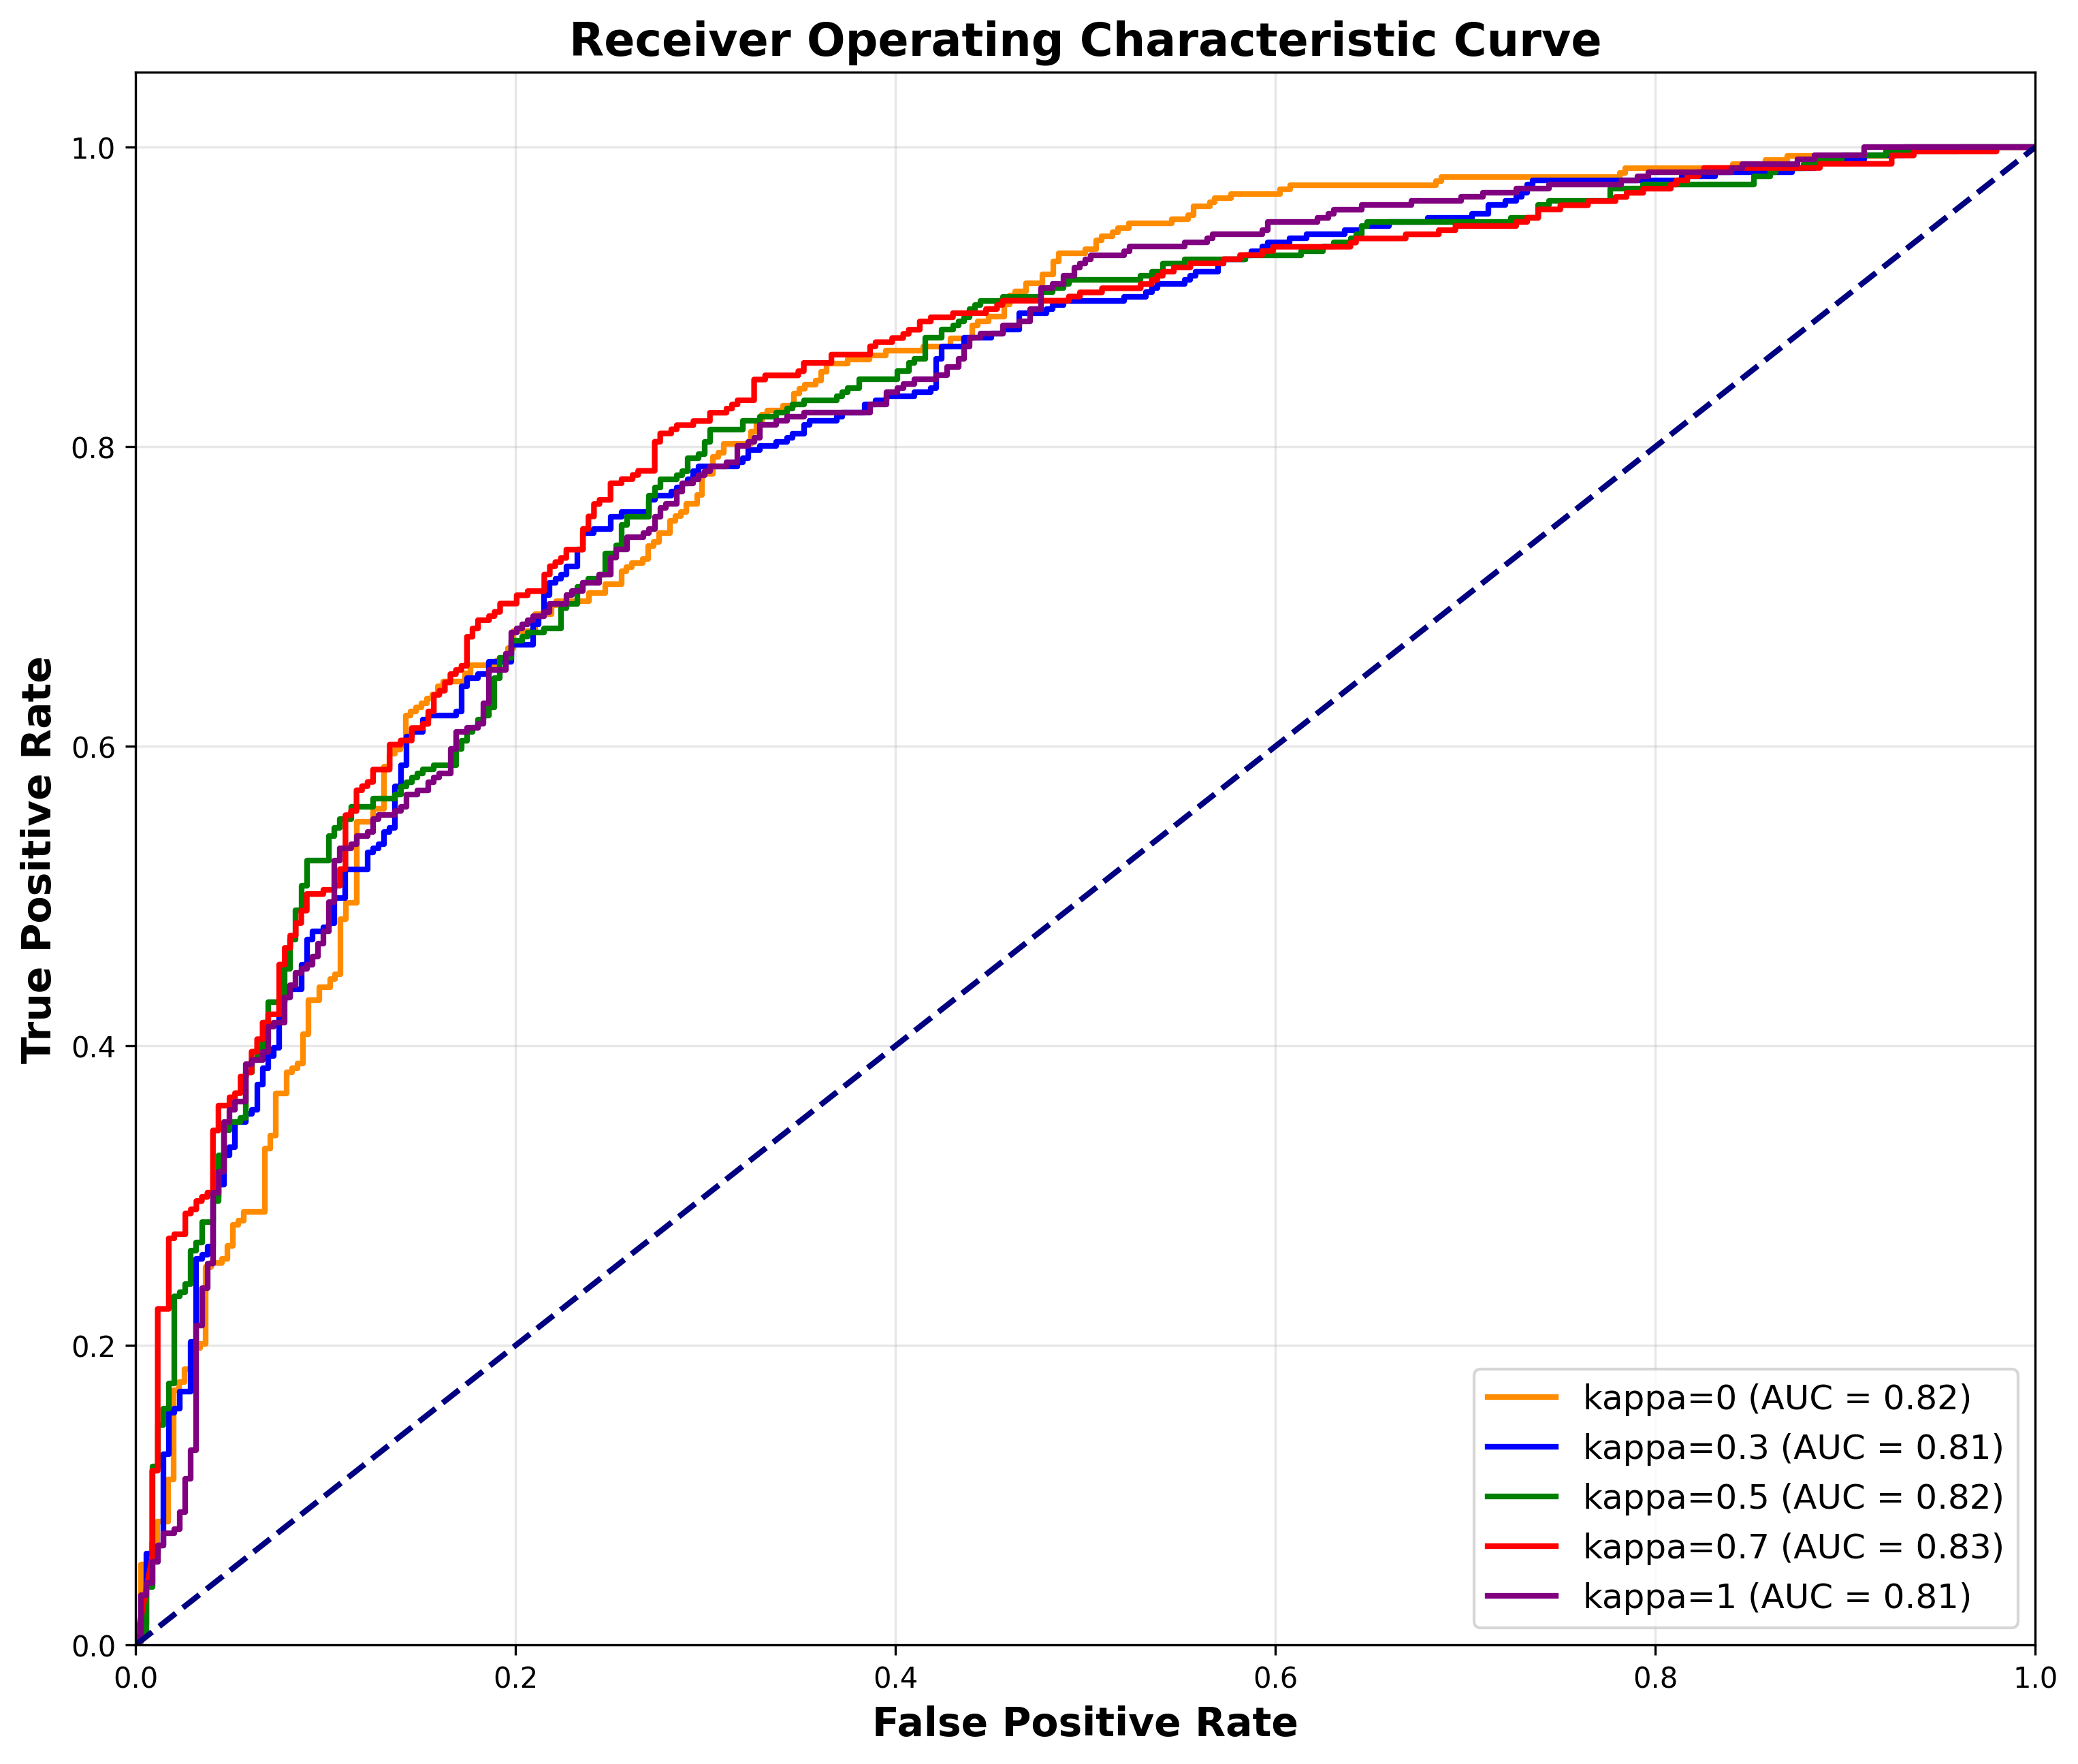

In [36]:
# Plot all ROC curves in one figure
def plot_all_roc_curves(roc_data):
    plt.figure(figsize=(12, 10), dpi=300)
    colors = ['darkorange', 'blue', 'green', 'red', 'purple']
    for i, (kappa, fpr, tpr, roc_auc) in enumerate(roc_data):
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2, label=f'kappa={kappa} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.title('Receiver Operating Characteristic Curve', fontsize=16, fontweight='bold')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, alpha=0.3)
    #plt.savefig('roc_curves_all_kappa.png')
    #plt.close()

plot_all_roc_curves(roc_data)